Labeled sequence of bitter peptides.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [45]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [46]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [47]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [48]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

bitter         seq
0    Positive         GFF
1    Positive  VYPFPPGIGG
2    Positive        EVLN
3    Positive    KAVPYPPQ
4    Positive          FV
..        ...         ...
635  Negative   MIFPGGPQL
636  Negative         HHL
637  Negative         HIR
638  Negative        NILP
639  Negative          NK

[640 rows x 2 columns]

In [49]:
#df = df.sample(frac=1, random_state=7)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [50]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [51]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [52]:
data_list = []

In [53]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [54]:
train_data, test_data = train_test_split(data_list, test_size=0.1, random_state=6)#1

In [55]:
train_data[0], test_data[0]

(Data(x=[7, 20], edge_index=[2, 12], y=1),
 Data(x=[4, 20], edge_index=[2, 6], y=1))

In [56]:
train_loader = DataLoader(train_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=64)

In [57]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[127, 20], edge_index=[2, 190], y=[32], batch=[127], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[142, 20], edge_index=[2, 220], y=[32], batch=[142], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[169, 20], edge_index=[2, 274], y=[32], batch=[169], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[210, 20], edge_index=[2, 356], y=[32], batch=[210], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[176, 20], edge_index=[2, 288], y=[32], batch=[176], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[183, 20], edge_index=[2, 302], y=[32], batch=[183], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[179, 20], edge_index=[2, 294], y=[32], batch=[179], ptr=[33])

Step 8:
Number of graphs in the current batch: 32
DataBatch(x=[174, 20], edge_index=[2, 284], y=[32], batch=[174], ptr

In [58]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [59]:
hidden_channels = 16
epochs = 30

In [60]:
model = GCN(hidden_channels=hidden_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(epochs):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.7049, Test Acc: 0.6094
Epoch: 001, Train Acc: 0.8108, Test Acc: 0.7500
Epoch: 002, Train Acc: 0.8368, Test Acc: 0.7812
Epoch: 003, Train Acc: 0.8385, Test Acc: 0.7969
Epoch: 004, Train Acc: 0.8368, Test Acc: 0.7812
Epoch: 005, Train Acc: 0.8490, Test Acc: 0.7969
Epoch: 006, Train Acc: 0.8594, Test Acc: 0.8438
Epoch: 007, Train Acc: 0.8576, Test Acc: 0.7812
Epoch: 008, Train Acc: 0.8715, Test Acc: 0.8281
Epoch: 009, Train Acc: 0.8576, Test Acc: 0.8281
Epoch: 010, Train Acc: 0.8819, Test Acc: 0.8594
Epoch: 011, Train Acc: 0.8941, Test Acc: 0.8125
Epoch: 012, Train Acc: 0.8993, Test Acc: 0.8750
Epoch: 013, Train Acc: 0.9080, Test Acc: 0.8438
Epoch: 014, Train Acc: 0.9010, Test Acc: 0.8281
Epoch: 015, Train Acc: 0.9080, Test Acc: 0.8594
Epoch: 016, Train Acc: 0.9115, Test Acc: 0.8281
Epoch: 017, Train Acc: 0.9045, Test Acc: 0.7812
Epoch: 018, Train Acc: 0.9201, Test Acc: 0.7656
Epoch: 019, Train Acc: 0.9132, Test Acc: 0.7969
Epoch: 020, Train Acc: 0.8837, Test Acc:

In [61]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [62]:
out.shape

torch.Size([64, 2])

In [63]:
lab.shape

torch.Size([64])

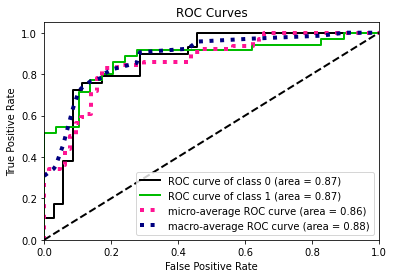

In [64]:
skplt.metrics.plot_roc(lab, out.detach().numpy())
plt.show()

In [65]:
model

GCN(
  (conv1): GCNConv(20, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=2, bias=True)
)

In [66]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [67]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [68]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'pred_val':out[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [69]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

## Graph level embedding

### All embeddings

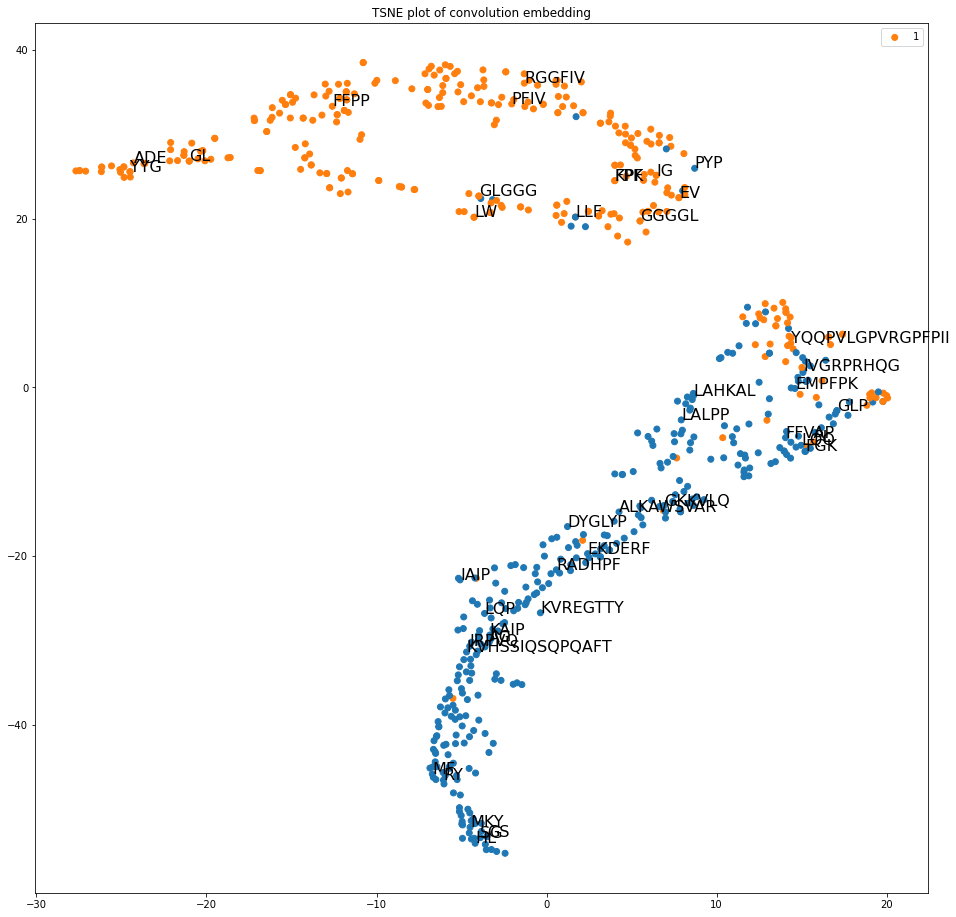

In [70]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    if i%15 == 0:
        plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]), size = 16)
plt.title('TSNE plot of convolution embedding')
plt.show()

### Train

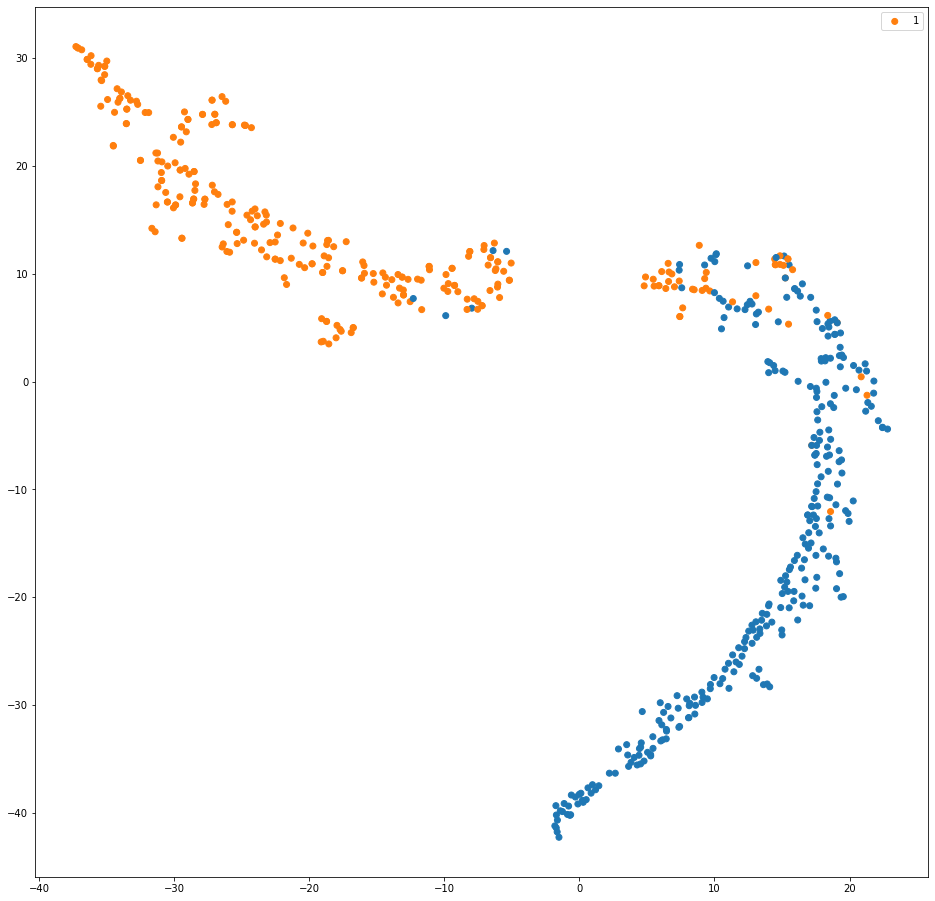

In [71]:
descs = []
conv_feats = np.zeros((len(train_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(train_graph_embeddings)):
    descs.append(train_graph_embeddings[i]['desc'])
    conv_feats[i] = train_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(train_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
plt.show()
#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))

#### Test

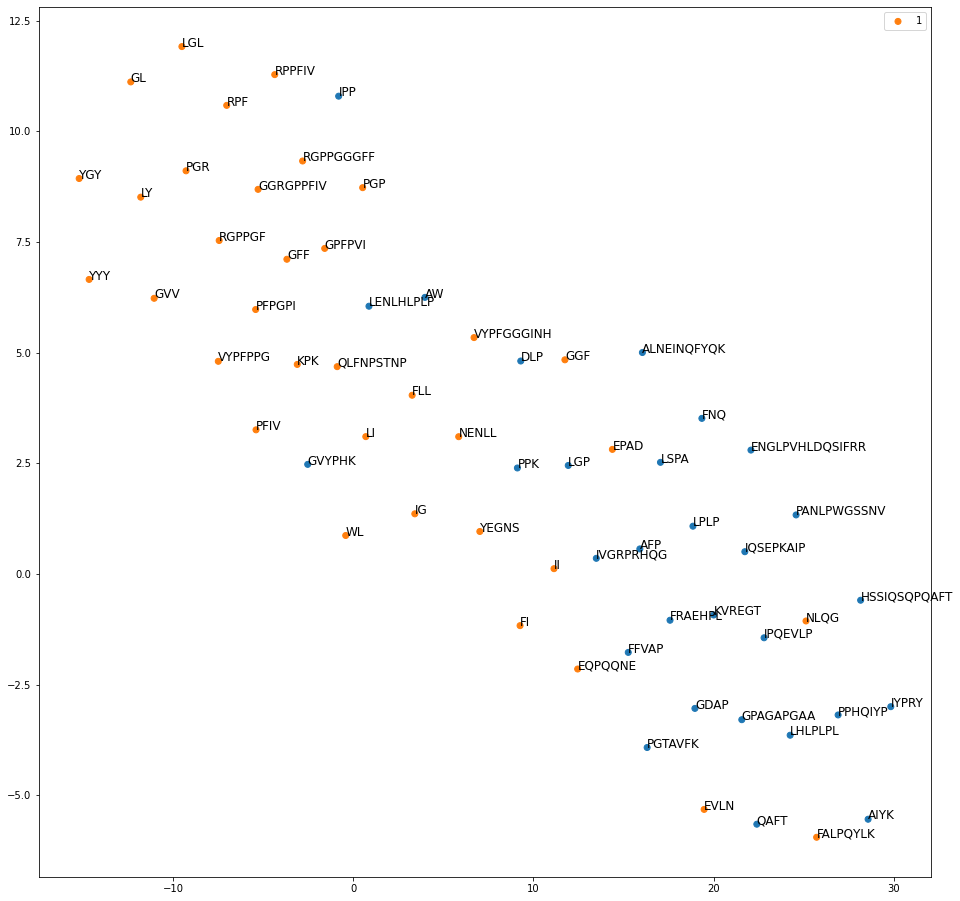

In [72]:
descs = []
conv_feats = np.zeros((len(test_graph_embeddings), 16))
labels = []
pred_vals = []
for i in range(len(test_graph_embeddings)):
    descs.append(test_graph_embeddings[i]['desc'])
    conv_feats[i] = test_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(test_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])

tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

plt.figure(figsize=(16, 16))
plt.legend(labels)
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend(labels)
for i, l in enumerate(descs):
    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]), size=12)
plt.show()

## Node level embeddings: All Data 

In [73]:
descs = []
conv_feats = []
labels = []
pred_vals = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats.append(all_graph_embeddings[i]['conv3_feats'].mean(axis = 1).detach().tolist())
    labels.append(all_graph_embeddings[i]['label'])
    pred_vals.append(all_graph_embeddings[i]['pred_val'])


In [74]:
pos_samples = []
neg_samples = []
for i in range(len(conv_feats)):
    if labels[i] == 1:
        pos_samples.append(np.mean(conv_feats[i]))
    else:
        neg_samples.append(np.mean(conv_feats[i]))

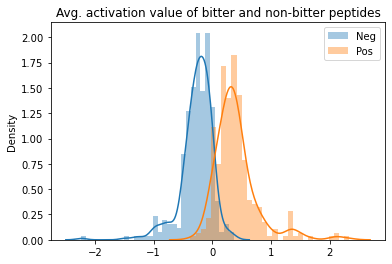

In [75]:
sns.distplot(neg_samples, label='Neg')
sns.distplot(pos_samples, label='Pos')
plt.legend()
plt.title('Avg. activation value of bitter and non-bitter peptides')
plt.show()

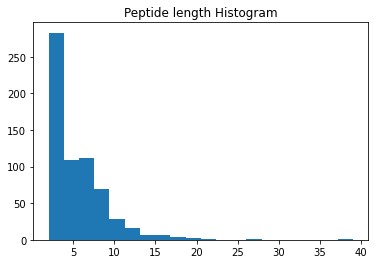

In [76]:
plt.hist([len(i) for i in descs], bins = 20)
plt.title('Peptide length Histogram')
plt.show()

In [77]:
pos_descs = {}
neg_descs = {}
for i in range(len(labels)):
    k = descs[i]
    v = conv_feats[i]
    if labels[i] == 1:
        for _, d in enumerate(k):
            if d in pos_descs.keys():
                pos_descs[d].append(v[_])
            else:
                pos_descs[d] = [v[_]]
    else:
        for _, d in enumerate(k):
            if d in neg_descs.keys():
                neg_descs[d].append(v[_])
            else:
                neg_descs[d] = [v[_]]

In [78]:
desc_keys = sorted(list(set(list(pos_descs.keys()) + list(neg_descs.keys()))))

In [79]:
pos_desc_avg = []
neg_desc_avg = []
desc_avg = []
pos_desc_count = np.arange(len(desc_keys))
neg_desc_count = np.arange(len(desc_keys))

for i, k in enumerate(desc_keys):
    if k in pos_descs.keys():
        pos_desc_avg.append(np.mean(pos_descs[k]))
        pos_desc_count[i] = pos_desc_count[i] + len(pos_descs[k])
    else:
        pos_desc_avg.append(0)

    if k in neg_descs.keys():
        neg_desc_avg.append(np.mean(neg_descs[k]))
        neg_desc_count[i] = neg_desc_count[i] + len(neg_descs[k])
    else:
        neg_desc_avg.append(0)


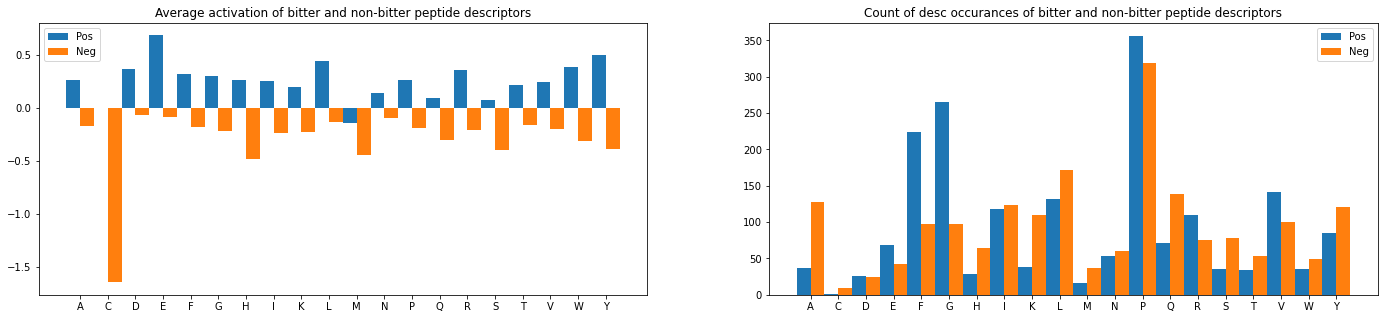

In [80]:
fig, ax = plt.subplots(1,2,figsize=(24,5))
ax[0].bar(x=np.arange(20)-0.25, height = pos_desc_avg, width=-.5)
ax[0].bar(x=np.arange(20)+0.25, height = neg_desc_avg, width=-.5)
ax[0].set_xticks(np.arange(20), desc_keys)
ax[0].legend(['Pos', 'Neg'])
ax[0].set_title('Average activation of bitter and non-bitter peptide descriptors')

ax[1].bar(x=np.arange(20)-0.25, height = pos_desc_count, width=-.5)
ax[1].bar(x=np.arange(20)+0.25, height = neg_desc_count, width=-.5)
ax[1].set_xticks(np.arange(20), desc_keys)
ax[1].legend(['Pos', 'Neg'])
ax[1].set_title('Count of desc occurances of bitter and non-bitter peptide descriptors')
plt.show()

Seq: VPPFLE, Label: 1, Cls prob: [-4.619754791259766, 5.085540771484375]


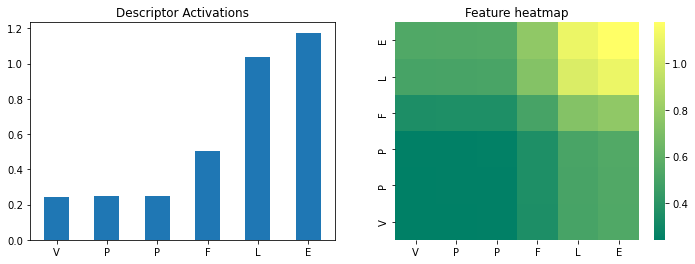

Seq: LRW, Label: 0, Cls prob: [2.1674249172210693, -1.9476922750473022]


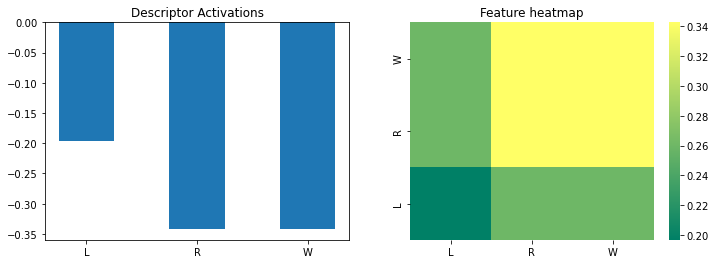

Seq: RRPPFF, Label: 1, Cls prob: [-3.5053980350494385, 3.760153293609619]


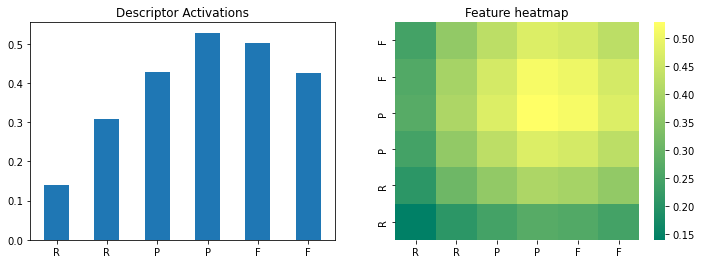

Seq: LAHKAL, Label: 0, Cls prob: [0.3600900173187256, -0.009473253041505814]


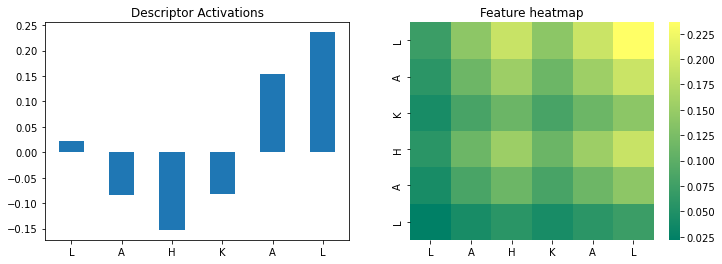

Seq: RPFFRPFFRPFF, Label: 1, Cls prob: [-3.556745767593384, 3.801978349685669]


Seq: IVGRPRHQG, Label: 0, Cls prob: [-0.13837793469429016, 0.4300477206707001]


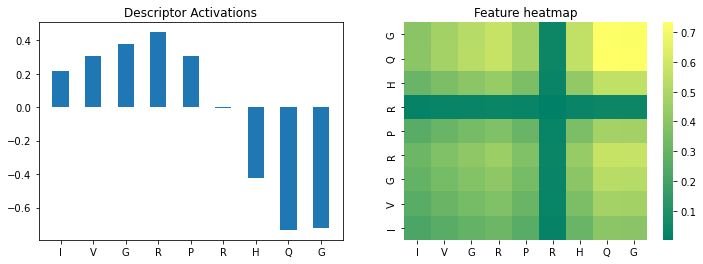

Seq: VIF, Label: 1, Cls prob: [-2.4667391777038574, 2.864157199859619]


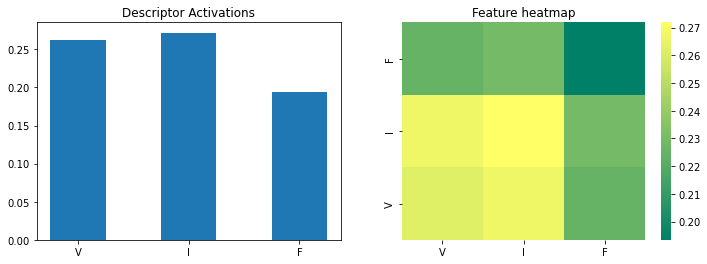

Seq: LPLP, Label: 0, Cls prob: [0.6455643177032471, -0.5012378692626953]


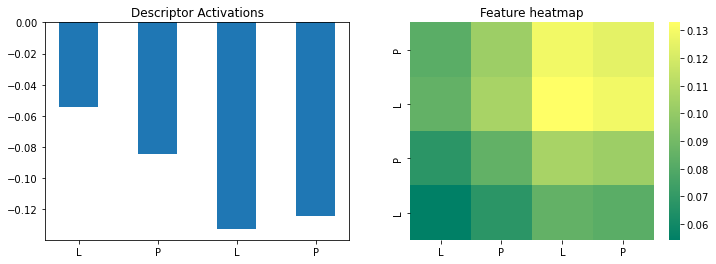

Seq: FQP, Label: 0, Cls prob: [2.9376916885375977, -2.655289888381958]


Seq: PLW, Label: 0, Cls prob: [2.83237886428833, -2.574629306793213]


Seq: PQAFP, Label: 0, Cls prob: [1.7620718479156494, -1.533339023590088]


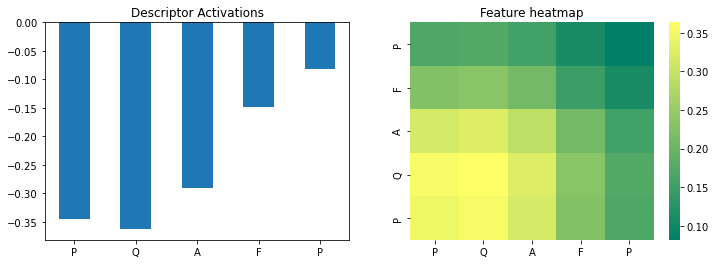

Seq: FLL, Label: 1, Cls prob: [-1.4157160520553589, 1.699852705001831]


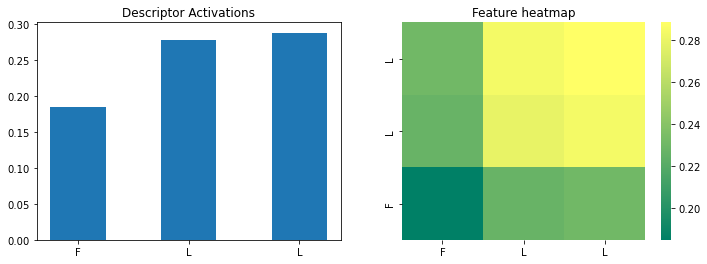

Seq: PPHQIYP, Label: 0, Cls prob: [2.7770087718963623, -2.468993902206421]


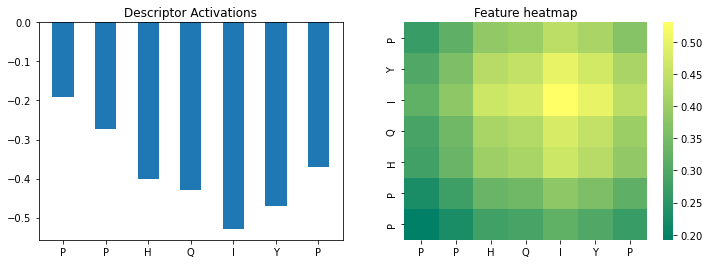

Seq: HIRL, Label: 0, Cls prob: [2.299873113632202, -2.073578119277954]


Seq: KVLPVP, Label: 0, Cls prob: [0.49922701716423035, -0.21535724401474]


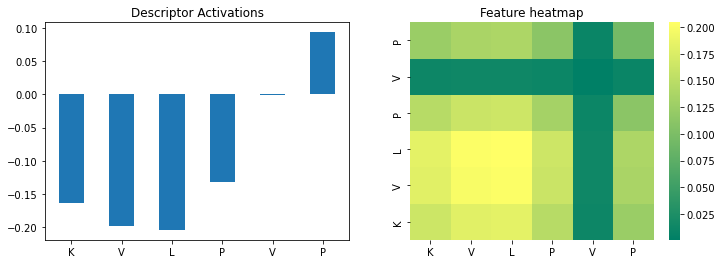

In [82]:
#i = np.random.randint(640)
#print(i)
for i in np.random.choice(640, 15):
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(12, 4))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #plt.plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    ax[0].set_title('Descriptor Activations')
    sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()

Seq: QQPVLGPVRGPFPI, Label: 1, Cls prob: [-0.7761502265930176, 1.0287914276123047]


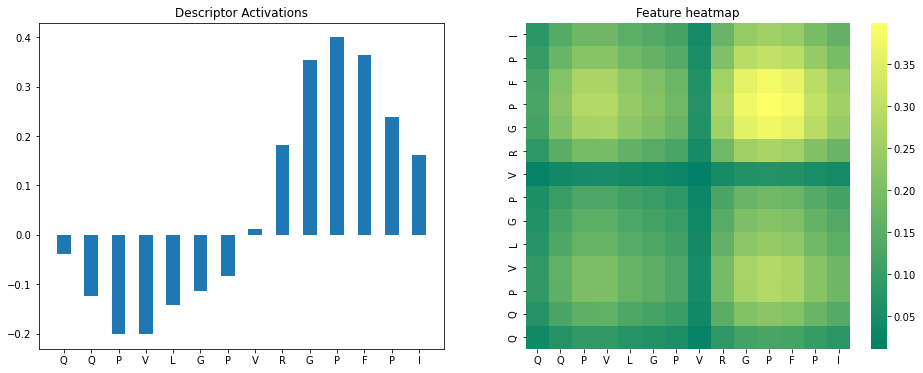

Seq: KFHSGIQSEPKAIP, Label: 0, Cls prob: [2.090786933898926, -1.847689151763916]


Seq: PVLGPVRGPFPIIV, Label: 1, Cls prob: [-1.4221956729888916, 1.7329272031784058]


Seq: KIYPSFQPQPLIYP, Label: 0, Cls prob: [3.0676286220550537, -2.68630051612854]


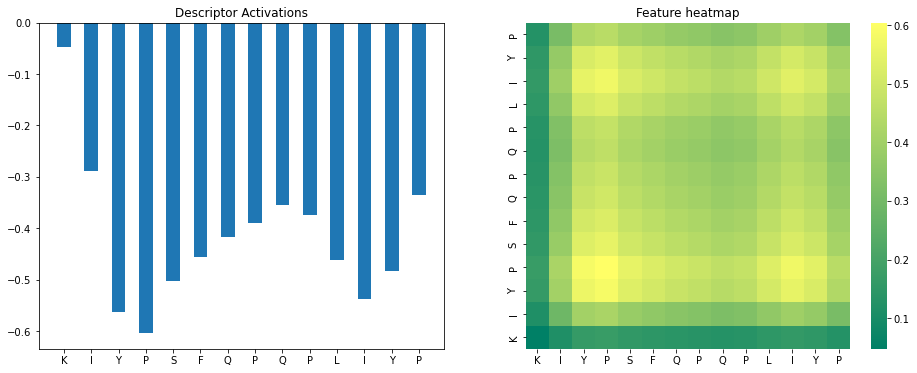

Seq: YQEPVLGPVRGPFPI, Label: 1, Cls prob: [-0.5294148921966553, 0.8137058019638062]


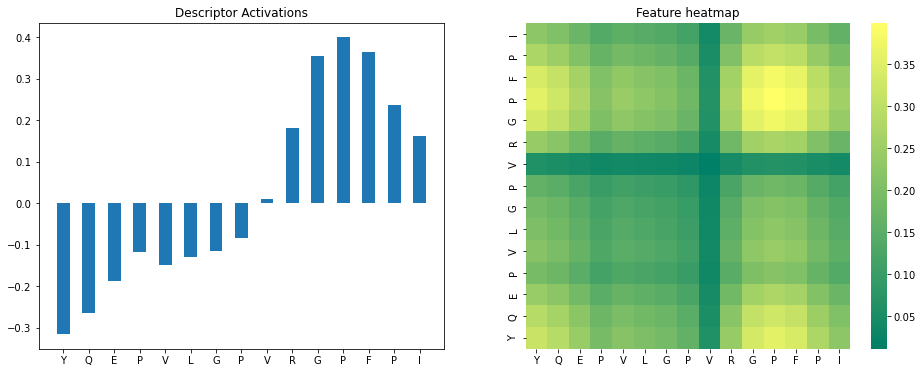

Seq: ENGLPVHLDQSIFRR, Label: 0, Cls prob: [1.1824480295181274, -0.9841312170028687]


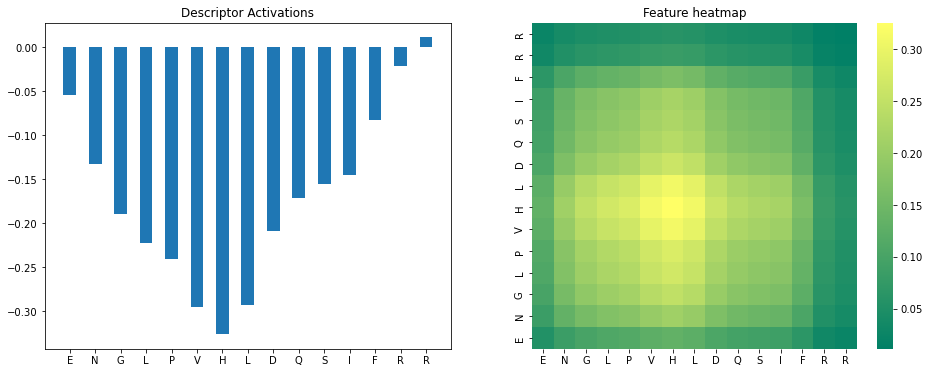

Seq: QPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.9358365535736084, 1.2377495765686035]


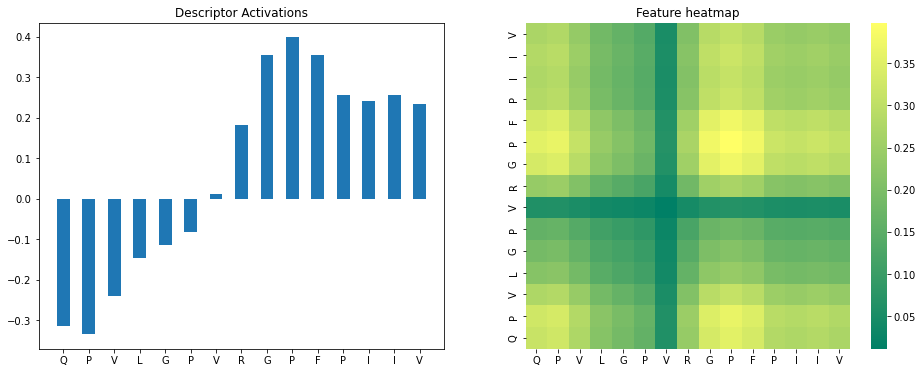

Seq: DKIYPSFQPQPLIYP, Label: 0, Cls prob: [3.3102781772613525, -2.994537115097046]


Seq: YQQPVLGPVRGPFPI, Label: 1, Cls prob: [-0.4159890115261078, 0.6750770211219788]


Seq: YQQPVLGPVRGPFPII, Label: 1, Cls prob: [-0.44324496388435364, 0.7154764533042908]


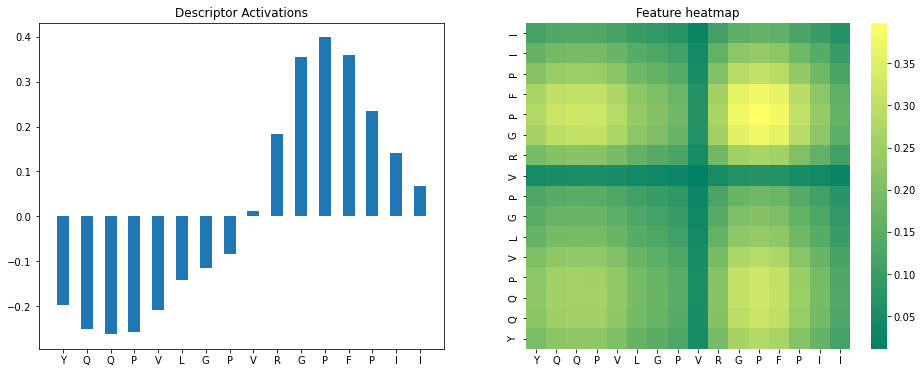

Seq: ENGLPVHLDQSIFRRP, Label: 0, Cls prob: [0.5907487273216248, -0.3839140236377716]


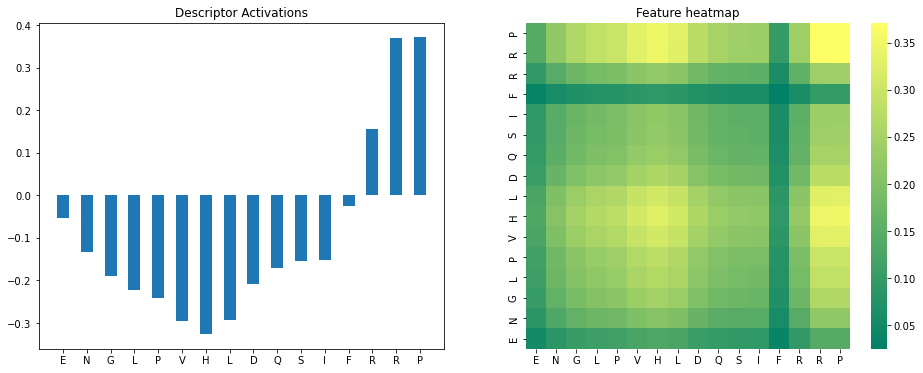

Seq: APKHKEMPFPKYPVEPF, Label: 1, Cls prob: [-1.2915359735488892, 1.65181565284729]


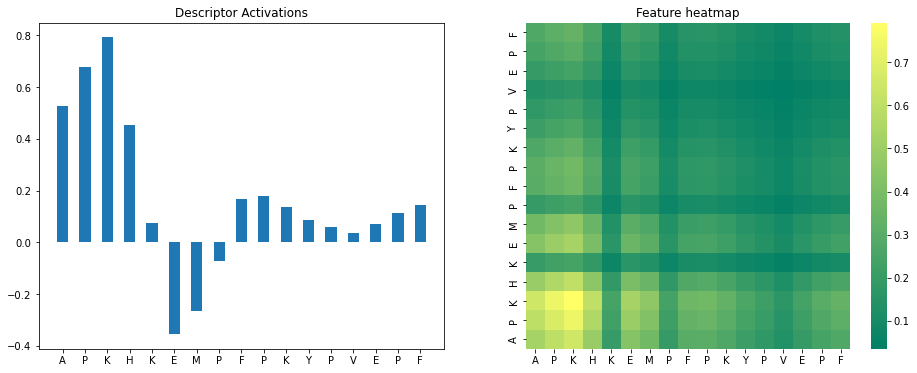

Seq: YQQPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.7066574096679688, 0.9869080781936646]


Seq: YQEPVLGPVRGPFPIIV, Label: 1, Cls prob: [-0.8067392110824585, 1.1092275381088257]


Seq: MAPKHKEMPFPKYPVEPF, Label: 1, Cls prob: [-0.7237205505371094, 1.0687471628189087]


Seq: LVYPFPGPIPNSLPQNIPP, Label: 0, Cls prob: [-0.30946433544158936, 0.6092861294746399]


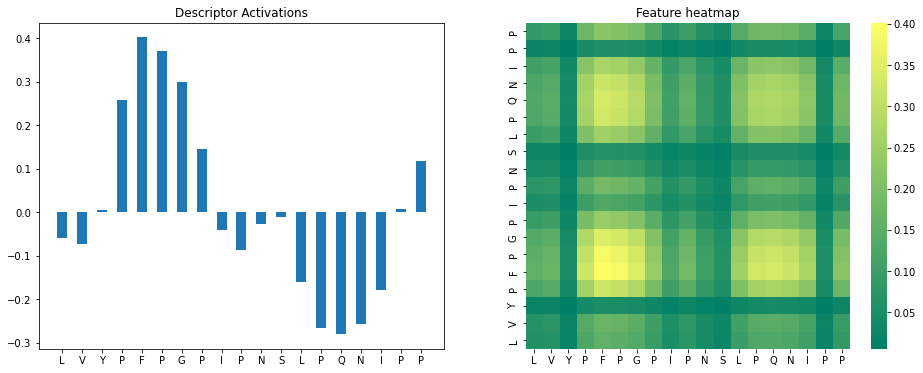

Seq: QDKIHPFAQTQSLVYPFPGP, Label: 1, Cls prob: [-0.7008764743804932, 0.9701549410820007]


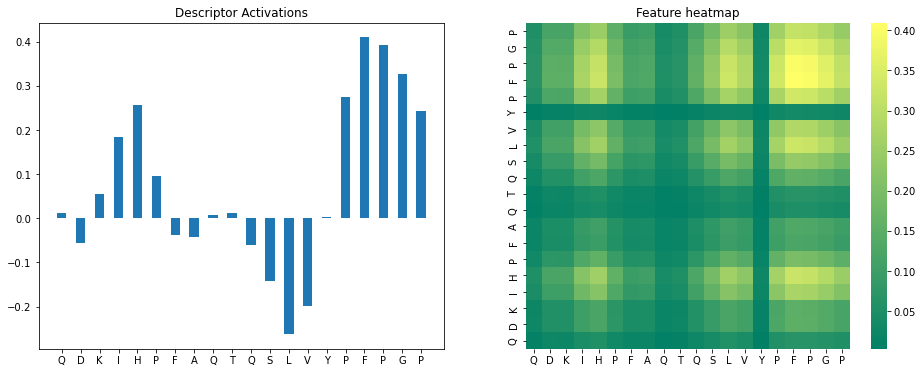

Seq: QNDKIHPFAQTQSLVYPFGPIP, Label: 1, Cls prob: [-0.728629469871521, 0.9959489703178406]


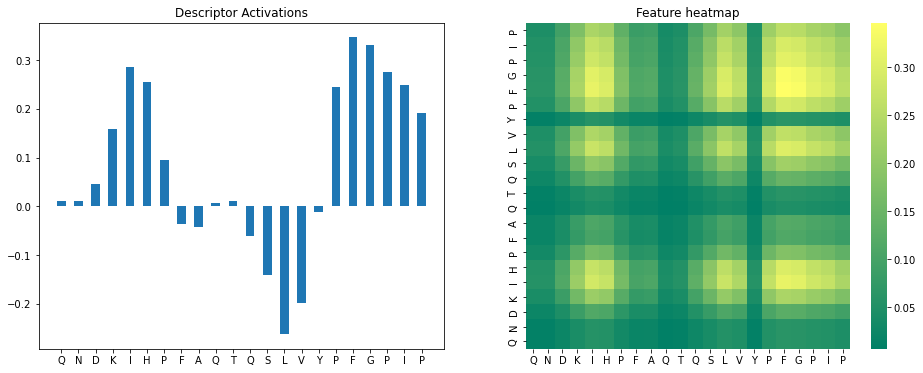

Seq: AQTQSLVYPFPGPIPNSLPQNIPPLTQ, Label: 1, Cls prob: [0.12654268741607666, 0.11119572818279266]


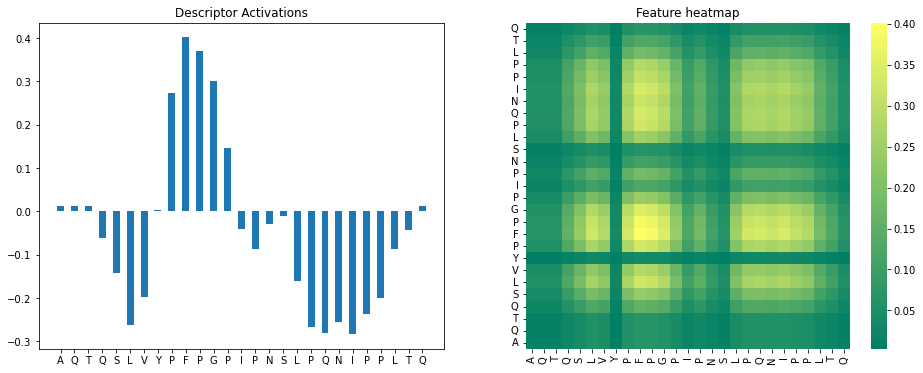

Seq: QNDKIHPFAQTQSLVYPFGPIPNSLPQNIPPLTQTPVVV, Label: 1, Cls prob: [-0.404035359621048, 0.6644793748855591]


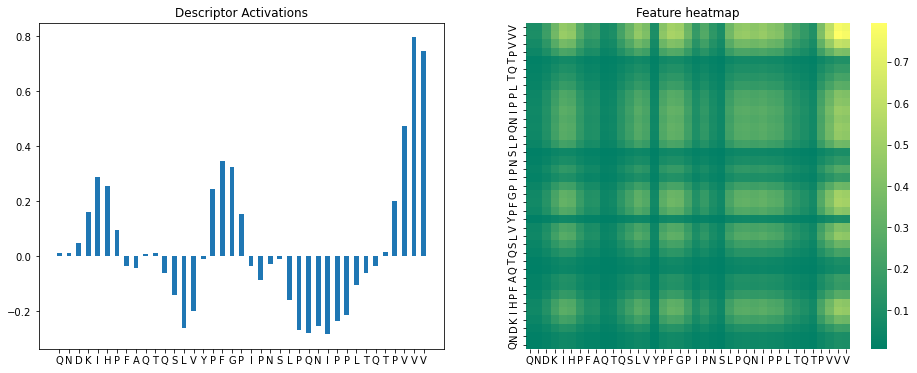

In [83]:
#i = np.random.randint(640)
#print(i)
for i in np.argsort([len(i) for i in descs])[-20:]:
    print(f'Seq: {descs[i]}, Label: {labels[i]}, Cls prob: {pred_vals[i].tolist()}')
    fig, ax = plt.subplots(1,2,figsize=(16, 6))
    #print(f'Activation: {conv_feats[i]}')
    ax[0].bar(x=np.arange(len(descs[i])), height = conv_feats[i], width=-.5)
    #plt.plot(conv_feats[i])
    ax[0].set_xticks(np.arange(len(descs[i])), [c for c in descs[i]])
    ax[0].set_title('Descriptor Activations')
    sns.heatmap(np.sqrt(np.rot90(np.abs(np.matmul(np.matrix(conv_feats[i]).T, np.matrix(conv_feats[i]))))), cmap = 'summer', ax = ax[1]) #annot=True, 

    ax[1].set_xticks(np.arange(len(descs[i]))+0.5, labels=[c for c in descs[i]])
    ax[1].set_yticks(np.arange(len(descs[i]))+0.5, labels=descs[i][::-1])
    ax[1].set_title('Feature heatmap')
    plt.show()